In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 32*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-01 09:40:12.732015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 09:40:12.951870: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 09:40:13.614181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [109]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
sim_name = sim_names[0]
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [110]:
class NN_Field(tu.NN_base):
    def __init__(self, x_range, y_range, depth, dim_2d, layer_num, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.depth = depth
        self.layer_num = layer_num
        self.dim_2d = dim_2d
        x = tf.constant(x_range, dtype=dtype)
        y = tf.constant(y_range, dtype=dtype)
        #Y,X = tf.meshgrid(x, y, indexing='ij')
        #X, Y = tf.meshgrid(x, y)
        Y, X = tf.meshgrid(x, y)
        self.X = X
        self.Y = Y
        self.domain_shape = X.shape
        self.build()
        
    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        scales = []
        biases = []
        
        rnd_init = tf.random_normal_initializer(stddev=1/6)
        W = tf.Variable(self.make_variables([self.depth, 3], rnd_init)
                        , dtype=self.dtype, name="W1")
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype, name="a1")
        b = tf.Variable(tf.zeros([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype , name="b1")
        
        weights.append(W)
        scales.append(a)
        biases.append(b)
        for i in range(self.layer_num-1):
            rnd_init = tf.random_normal_initializer(stddev=1/(2*self.depth))
            W = tf.Variable(self.make_variables([self.depth, self.depth], rnd_init)
                        , dtype=self.dtype, name=f"W{i+2}")
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            a = tf.Variable(tf.ones([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype, name=f"a{i+2}")
            b = tf.Variable(tf.zeros([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype, name=f"b{i+2}")
        
            weights.append(W)
            scales.append(a)
            biases.append(b)
            
        rnd_init = tf.random_normal_initializer(stddev=1/4)
        W = tf.Variable(self.make_variables([2, self.depth], rnd_init)
                        , dtype=self.dtype, name=f"W{self.layer_num+1}")
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 2], dtype=self.dtype), dtype=self.dtype, name=f"a{self.layer_num+1}")
        b = tf.Variable(tf.zeros([1, 1, 2], dtype=self.dtype), dtype=self.dtype, name=f"b{self.layer_num+1}")
        
        weights.append(W)
        scales.append(a)
        biases.append(b)

        self.Ws = weights
        self.scales = scales
        self.bs = biases

    @tf.function
    def net(self, ts):
        #T = tf.fill(self.domain_shape, t)
#         H = tf.concat([tf.expand_dims(self.X, 0), 
#                        tf.expand_dims(self.Y, 0), 
#                        tf.expand_dims(T, 0)], axis=0)
    

    
         
        
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        #print(T)
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat([tf.concat([self.X[tf.newaxis, :, :, tf.newaxis], 
                                  self.Y[tf.newaxis, :, :, tf.newaxis],
                                  T[:, :, i:i+1][tf.newaxis, :, :, :]], axis=3) for i in range(T.shape[-1])], axis=0)
        #print(H)
        def act(x):
            return x*x*tf.sigmoid(x)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            #print(W)
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #outputs =  mul_outputs + b
            #print(outputs)
            #H = tf.tanh(outputs)
            H = tf.sigmoid(outputs)
            #print(H)

        return outputs

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2



In [124]:

# x = tf.constant(np.arange(x_slice.start, x_slice.stop)*pattern.simulation.L[0]/pattern.simulation.n[0], 
#                 dtype=tf.float32)
# y = tf.constant(np.arange(y_slice.start, y_slice.stop)*pattern.simulation.L[1]/pattern.simulation.n[0], 
#                 dtype=tf.float32)
x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]
optimizer=keras.optimizers.Adam(learning_rate=2e-4)
pinn = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()
#x = tf.constant(x_range[x_slice], dtype=tf.float32)
#y = tf.constant(y_range[y_slice], dtype=tf.float32)
#x = 2.0 * (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x)) - 1.0
#y = 2.0 * (y - tf.reduce_min(y)) / (tf.reduce_max(y) - tf.reduce_min(y)) - 1.0
#X,Y = tf.meshgrid(x, y)

D_u = pattern.params["D_u"]
D_v = pattern.params["D_u"]
sigma_u = pattern.params["sigma_u"]
sigma_v = pattern.params["sigma_v"]
mu_u = pattern.params["mu_u"]
rho_u = pattern.params["rho_u"]
rho_v = pattern.params["rho_v"]
kappa_u = pattern.params["kappa_u"]
@tf.function
def grads(pinn, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        #tape.watch(t)
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            tape2.watch(t)     
            
            outputs = pinn.net(t)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, t)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, t)
        
    u_xx = tape.gradient(u_x, pinn.X)
    u_xy = tape.gradient(u_x, pinn.Y)
    u_yx = tape.gradient(u_y, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    v_xy = tape.gradient(v_x, pinn.Y)
    v_yx = tape.gradient(v_y, pinn.X)
    #return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))
        
        
#@tf.function
def train_step(elements):
    #t = elements[0][0]
    with tf.GradientTape(persistent=False) as tape:         
        trainables = pinn.trainable_variables        
        outputs = pinn.net(elements[0])

        u = outputs[0, :, :, 0]
        v = outputs[0, :, :, 1]
    
        u_fft = tf.signal.fft2d(tf.cast(u, tf.complex64))
        v_fft = tf.signal.fft2d(tf.cast(v, tf.complex64))

        f = u * u * v / (1.0 + kappa_u * u * u)
        f_uv =  rho_u * f - mu_u * u + sigma_u
        g_uv = -rho_v * f + sigma_v


        f_uv_fft = tf.signal.fft2d(tf.cast(f_uv, tf.complex64))
        g_uv_fft = tf.signal.fft2d(tf.cast(g_uv, tf.complex64))
        #kx = x[:,3:4]
        #ky = x[:,4:5]
        kx = tf.constant([i for i in range(u_fft.shape[1])], dtype=tf.complex64)
        ky = tf.constant([i for i in range(v_fft.shape[1])], dtype=tf.complex64) 
        kx = tf.ones(pinn.X.shape, dtype=tf.complex64) * kx[:, tf.newaxis]
        ky = tf.ones(pinn.Y.shape, dtype=tf.complex64) * ky[tf.newaxis, :]
        kxkx =  - 2*np.pi*np.pi*(kx**2 + ky**2)
        #print(kxkx)
        f_u =   D_u * kxkx*u_fft + f_uv_fft
        f_v =   D_v * kxkx*v_fft + g_uv_fft



        l2_res_u = tf.math.real(tf.reduce_sum(f_u*tf.math.conj(f_u)))
        l2_res_v = tf.math.real(tf.reduce_sum(f_v*tf.math.conj(f_v)))

        u_diff = u - elements[1][0, 0, :, :]
        v_diff = v - elements[1][0, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v 
        #l2 = l2_u_obs + l2_v_obs  
        
        
    grads = tape.gradient(l2, trainables)
    #print(grads)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)
    #return (l2_u_obs, l2_v_obs)


@tf.function
def train_step_finit_diff(elements):
    #t = elements[0][0]
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        #tape.watch(t)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)            
            tape2.watch(elements[0])
            
            outputs = pinn.net(elements[0])            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn.X)
            u_y = tape2.gradient(u, pinn.Y)
            #u_t = tape2.gradient(u, elements[0])
            
            v_x = tape2.gradient(v, pinn.X)
            v_y = tape2.gradient(v, pinn.Y)
            #v_t = tape2.gradient(v, elements[0])
            
        
        u_xx = tape.gradient(u_x, pinn.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn.Y)
        v_xx = tape.gradient(v_x, pinn.X)
        v_yy = tape.gradient(v_y, pinn.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        
#         f = u * u * v / (1.0 + kappa_u * u * u)
#         f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u #- u_t
#         f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v #- v_t
        
        
        
        u_diff = u - elements[1][0, 0, :, :]
        v_diff = v - elements[1][0, 1, :, :]        
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)
                
        delta_X2 = (pinn.X[1:-1, :]-pinn.X[2:, :])**2        
        delta_Y2 = (pinn.Y[:, 1:-1]-pinn.Y[:, 2:])**2
        u_xx_2 = (u[0, :-2, :] + u[0, 2:, :] - 2.0*u[0, 1:-1, :])/delta_X2
        u_yy_2 = (u[0, :, :-2] + u[0, :, 2:] - 2.0*u[0, :, 1:-1])/delta_Y2
        v_xx_2 = (v[0, :-2, :] + v[0, 2:, :] - 2.0*v[0, 1:-1, :])/delta_X2
        v_yy_2 = (v[0, :, :-2] + v[0, :, 2:] - 2.0*v[0, :, 1:-1])/delta_Y2
        
        u_xx_diff = u_xx[1:-1, :] - u_xx_2
        u_yy_diff = u_yy[:, 1:-1] - u_yy_2
        v_xx_diff = v_xx[1:-1, :] - v_xx_2
        v_yy_diff = v_yy[:, 1:-1] - v_yy_2
        
        
        l2_res_u_xx = tf.reduce_sum(u_xx_diff**2)
        l2_res_u_yy = tf.reduce_sum(u_yy_diff**2)
        l2_res_v_xx = tf.reduce_sum(v_xx_diff**2)
        l2_res_v_yy = tf.reduce_sum(v_yy_diff**2)


#         l2_res_u = tf.reduce_sum(f_u**2)
#         l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u_xx + l2_res_u_yy + l2_res_v_xx + l2_res_v_yy
        
        
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u_obs, l2_v_obs, l2_res_u_xx, l2_res_u_yy, l2_res_v_xx, l2_res_v_yy)#, l2_res_u_xyyx, l2_res_v_xyyx)

In [112]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [134]:
#optimizer.lr.assign(1e-5)
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=200+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=10,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 8741817.0 u: 30882.41015625, v: 2003.044189453125,
 Res u: 554992.5, Res v: 8153939.5 

Time taken: 0.71s

Start of epoch 10
at epoch 10
 total loss: 4772818.0 u: 24013.580078125, v: 1118.7418212890625,
 Res u: 297973.3125, Res v: 4449712.5 

Time taken: 5.97s

Start of epoch 20
at epoch 20
 total loss: 2463783.75 u: 20017.6796875, v: 669.3466796875,
 Res u: 151910.359375, Res v: 2291186.25 

Time taken: 6.09s

Start of epoch 30
at epoch 30
 total loss: 1197071.5 u: 17825.4765625, v: 443.0726013183594,
 Res u: 73166.2421875, Res v: 1105636.75 

Time taken: 5.00s

Start of epoch 40
at epoch 40
 total loss: 547610.375 u: 16702.05859375, v: 331.29913330078125,
 Res u: 32991.953125, Res v: 497585.09375 

Time taken: 3.88s

Start of epoch 50
at epoch 50
 total loss: 238842.90625 u: 16167.755859375, v: 277.2293701171875,
 Res u: 13942.3876953125, Res v: 208455.53125 

Time taken: 3.73s

Start of epoch 60
at epoch 60
 total loss: 102609.734375 u: 1593

In [135]:
def sum_per(arr, element_nums_by=2):
    return np.sum(arr.reshape(-1, element_nums_by), axis=1)

losses2 = np.array(losses)
element_nums_by = 1
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],
                        # sum_per(losses2[:, 4], element_nums_by)[:, np.newaxis],
                        # sum_per(losses2[:, 5], element_nums_by)[:, np.newaxis]
                        ], axis=1)

#losses2.shape

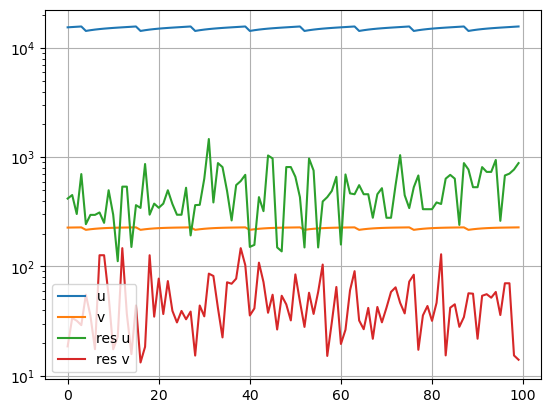

In [136]:
plt.plot(losses2[:, 0][-100:], label='u')
plt.plot(losses2[:, 1][-100:], label='v')
plt.plot(losses2[:, 2][-100:], label='res u')
plt.plot(losses2[:, 3][-100:], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [137]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))


In [138]:
def RMSE(arr1, arr2):
    return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))

u:  0.15093432
v:  0.08158878
u_xx:  0.5571352
v_xx:  0.41818342
u_yy:  0.55368674
v_yy:  0.40523878


In [126]:
def RMSE(arr1, arr2):
    return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))

u:  0.67322505
v:  1.5484012
u_xx:  0.5571352
v_xx:  0.41818342
u_yy:  0.55368674
v_yy:  0.40523878


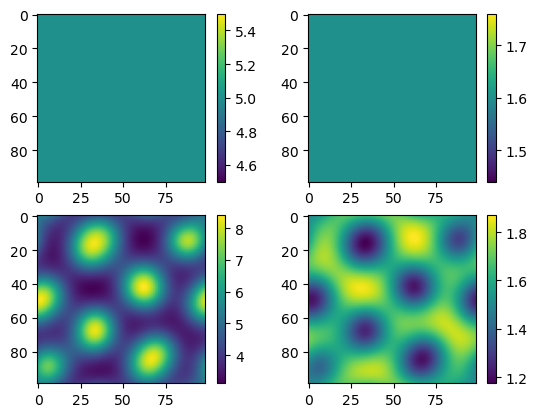

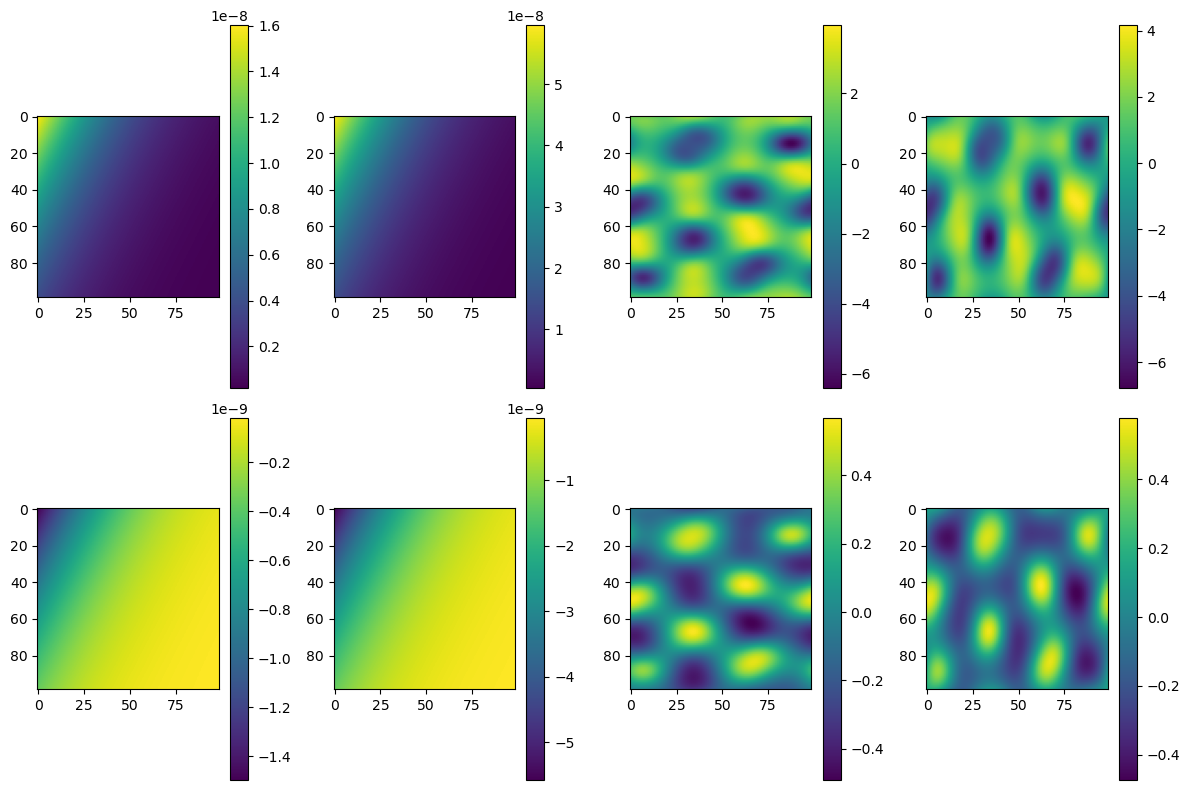

In [139]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(241)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(242)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(243)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(244)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(245)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(246)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(247)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(248)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

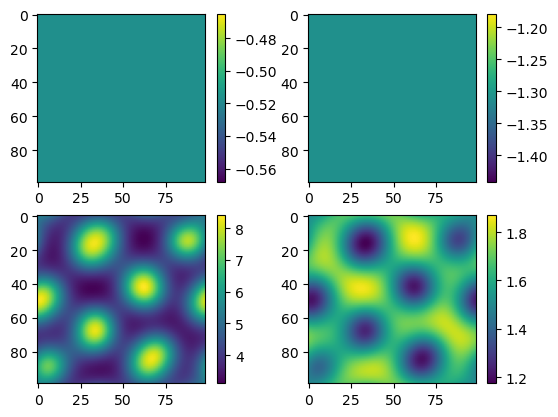

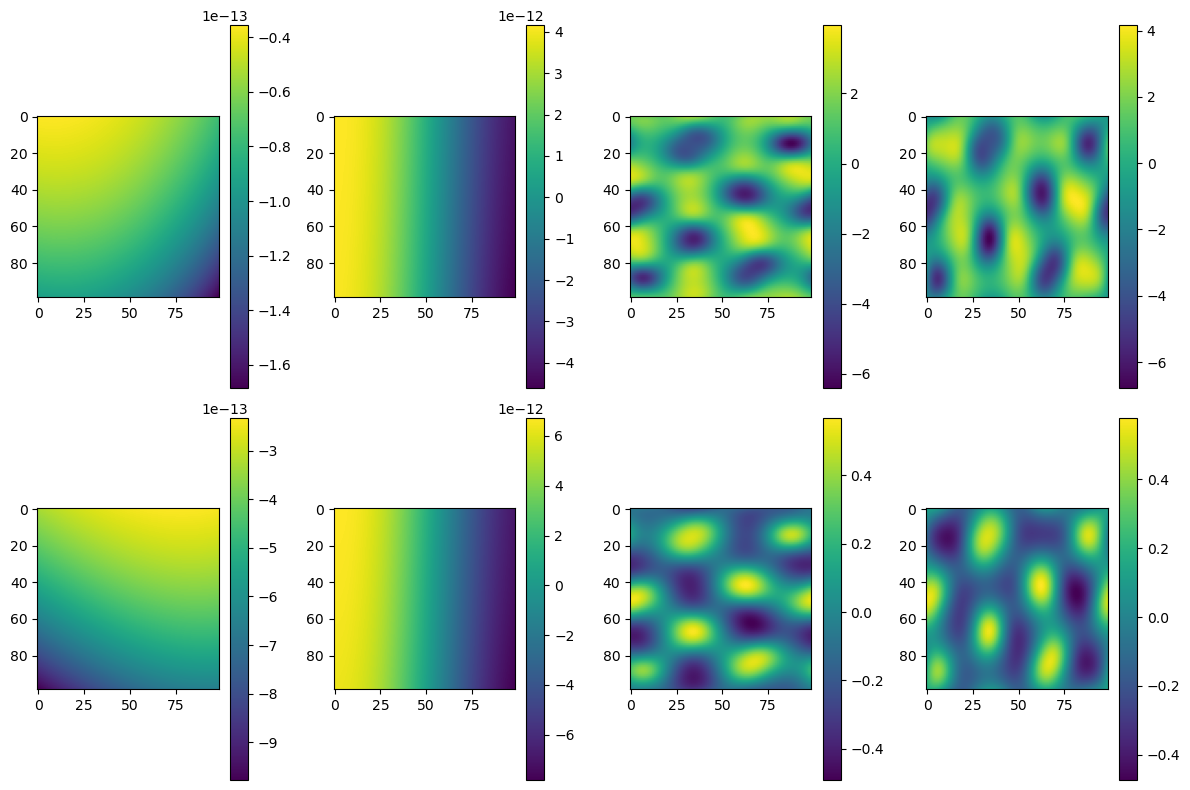

In [127]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(241)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(242)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(243)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(244)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(245)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(246)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(247)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(248)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [118]:
pattern.c_xx.shape

(2, 35, 35, 2)

In [68]:
        
class NN_Field2(tf.Module):
    def __init__(self, depth, dim_2d, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.depth = depth
        self.dim_2d = dim_2d
        self.dtype = dtype
        self.__version__ = 0.1
        self.build()

    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        biases = []
        
        W = tf.Variable(self.make_variables([3, 128], tf.random_normal_initializer())
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([128, 1, 1], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        biases.append(b)
        for i in range(self.depth-1):
            W = tf.Variable(self.make_variables([128, 128], tf.random_normal_initializer())
                        , dtype=self.dtype)
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([128, 1, 1], dtype=self.dtype), dtype=self.dtype)
        
            weights.append(W)
            biases.append(b)
            
        W = tf.Variable(self.make_variables([128, 2], tf.random_normal_initializer())
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([2,1,1], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        biases.append(b)

        self.Ws = weights
        self.bs = biases

    @tf.function
    def net(self, X, Y, t):        
        #x = 2.0 * (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x)) - 1.0
        #y = 2.0 * (y - tf.reduce_min(y)) / (tf.reduce_max(y) - tf.reduce_min(y)) - 1.0
        #X,Y = tf.meshgrid(x, y)
        #X = 2.0 * (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X)) - 1.0
        #Y = 2.0 * (Y - tf.reduce_min(Y)) / (tf.reduce_max(Y) - tf.reduce_min(Y)) - 1.0
        T = tf.fill(X.shape, t)
        
        H = tf.concat([tf.expand_dims(X, 0), 
                       tf.expand_dims(Y, 0), 
                       tf.expand_dims(T, 0)], axis=0)
        print(H)
        mul_outputs = tf.tensordot(self.Ws[0], H, axes=[[0], [0]])
        print(mul_outputs)
        outputs = tf.add(mul_outputs, self.bs[0])
        print(outputs)
        H = tf.tanh(outputs)
        for W, b in zip(self.Ws[1:], self.bs[1:]):
            mul_outputs = tf.tensordot(W, H, axes=[[0], [0]])
            print(mul_outputs)
            outputs = tf.add(mul_outputs, b)
            print(outputs)
            H = tf.tanh(outputs)
            print(H)

        return outputs

    def __call__(self, inputs):
        """Defines the computation from inputs to outputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """
        X = tf.cast(inputs, self.dtype)
        return self.net(X)

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2

    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.

        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]

        """
        partials = [tape.gradient(outputs[i], inputs) for i in range(len(outputs))]
        return partials

    def copy(self):
        return copy.deepcopy(self)

    def save(self, path_dir, name):
        path = pathlib.PurePath(path_dir).joinpath(name)
        # tf.saved_model.save(self, str(path))
        #
        # import os
        # if not pathlib.Path(path.joinpath(name)).exists():
        #   os.makedirs(path.joinpath(name))
        with open(f"{str(path)}.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def restore(cls, path_dir, name):
        path = pathlib.PurePath(path_dir).joinpath(name)
        # asset = tf.saved_model.load(str(path))
        with open(f"{str(path)}.pkl", "rb") as f:
            model = pickle.load(f)
        return model

In [4]:
lb = pattern.dataset['lb']
ub = pattern.dataset['ub']

obs_inputs = pattern.dataset['obs_input'].astype(np.float32)
obs_outputs = pattern.dataset['obs_output'].astype(np.float32)
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs
ds = TINN_Dataset(tf.float32, obs_X, pde_X)

In [238]:
class Koch_Meinhard_F(Loss):
    def __init__(
        self,
        D_u: PDE_Parameter,
        D_v: PDE_Parameter,
        sigma_u: PDE_Parameter,
        sigma_v: PDE_Parameter,
        mu_u: PDE_Parameter,
        rho_u: PDE_Parameter,
        rho_v: PDE_Parameter,
        kappa_u: PDE_Parameter,
        loss_grad_type=Loss_Grad_Type.BOTH,
        regularise=True,
        print_precision=".5f",
        **kwargs,
    ):
        """Koch_Meinhard PDE loss

        if the parameter is None, it becomes traiable with initial value set as init_vale,
        otherwise, it will be a constant
        alpha_u and alpha_v are scales that we use to normalise the u and v.
        """

        super().__init__(
            name="Loss_Koch_Meinhard",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("res u", "res v"),
            print_precision=print_precision,
            **kwargs,
        )

        self._trainables_ = ()

        self.D_u = D_u.build()
        self._trainables_ += D_u.trainable
        self.D_v = D_v.build()
        self._trainables_ += D_v.trainable
        self.sigma_u = sigma_u.build()
        self._trainables_ += sigma_u.trainable
        self.sigma_v = sigma_v.build()
        self._trainables_ += sigma_v.trainable
        self.mu_u = mu_u.build()
        self._trainables_ += mu_u.trainable
        self.rho_u = rho_u.build()
        self._trainables_ += rho_u.trainable
        self.rho_v = rho_v.build()
        self._trainables_ += rho_v.trainable
        self.kappa_u = kappa_u.build()
        self._trainables_ += kappa_u.trainable

    #@tf.function
    def residual(self, pinn, x):

        #(y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy) = self.derivatives(pinn, x)
        y = pinn.net(x[:, :3])
        u = tf.cast(y[:, 0], tf.complex64)
        v = tf.cast(y[:, 1], tf.complex64)

        D_u = tf.cast(self.D_u.get_value(x), tf.complex64)
        D_v = tf.cast(self.D_v.get_value(x), tf.complex64)
        sigma_u = tf.cast(self.sigma_u.get_value(x), tf.complex64)
        sigma_v = tf.cast(self.sigma_v.get_value(x), tf.complex64)
        mu_u = tf.cast(self.mu_u.get_value(x), tf.complex64)
        rho_u = tf.cast(self.rho_u.get_value(x), tf.complex64)
        rho_v = tf.cast(self.rho_v.get_value(x), tf.complex64)
        kappa_u = tf.cast(self.kappa_u.get_value(x), tf.complex64)

        
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_uv = rho_u * f - mu_u * u + sigma_u
        g_uv = -rho_v * f + sigma_v
        
        u_fft = tf.signal.fft2d(u)
        v_fft = tf.signal.fft2d(v)
        f_uv_fft = tf.signal.fft2d(f_uv)
        g_uv_fft = tf.signal.fft2d(g_uv)
        kx = x[:,3:4]
        ky = x[:,4:5]
        kxkx = - 2*np.pi*np.pi* D_u * (kx**2 + ky**2)
        f_u =  kxkx*u_fft + f_uv_fft
        f_v =  kxkx*v_fft + g_uv_fft

        # return (f_u / tf.math.reduce_std(f_u), f_v / tf.math.reduce_std(f_v))
        return (f_u, f_v)

In [239]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)
layers = [3, 128, 128, 128, 128, 128, 2]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
obs_loss = Observation_Loss(layers,
                            loss_grad_type=  Loss_Grad_Type.PINN)
simulation = pattern.simulation
pde_resKMF = Koch_Meinhard_F(
                        D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                        D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                        #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                        kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                        #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, params_ac["mu_u"]*init_param_perc ,dtype=pinnKM.dtype),
                        mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                        #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, params_ac["rho_u"]*init_param_perc,dtype=pinnKM.dtype),
                        rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                        #rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, params_ac["rho_v"]*init_param_perc,dtype=pinnKM.dtype),                    
                        rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                        #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, params_ac["sigma_u"]*init_param_perc,dtype=pinnKM.dtype),
                        sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                        #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, params_ac["sigma_v"]*init_param_perc,dtype=pinnKM.dtype),
                        sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                       regularise=False,
                       loss_grad_type=  Loss_Grad_Type.BOTH
        )
norm_l2 = L2()

#@tf.function
def train_step(elements):
    with tf.GradientTape(persistent=True) as tape:        
        items = obs_loss.residual(pinn, elements[0])
        items2 = pde_resKMF.residual(pinn, elements[1])
        l2_items1 = norm_l2.reduce_norm(items)
        l2_items2 = norm_l2.reduce_norm(items2)
        l2 = tf.reduce_sum(l2_items) + tf.reduce_sum(l2_items2)       
        trainables = pinn.trainable_variables
        
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return l2

In [240]:
losses = tu.train(epochs=1000+1,
                  batch_size=81,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  epoch_callback=None)


Start of epoch 0


2023-01-30 15:21:00.359477: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


InvalidArgumentError: {{function_node __wrapped__FFT2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input must have rank of at least 2 but got: [81] [Op:FFT2D]

In [217]:
def to_2d(x):
    return x.reshape((x_slice.stop - x_slice.start, y_slice.stop - y_slice.start))

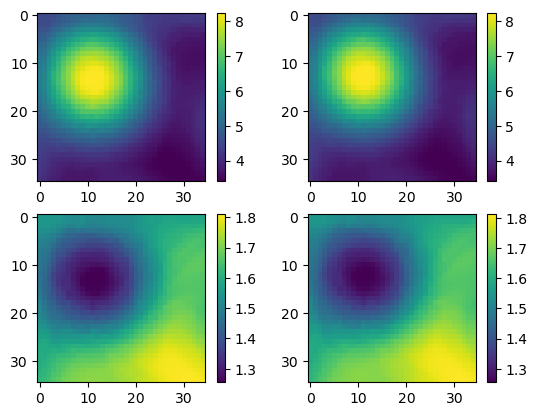

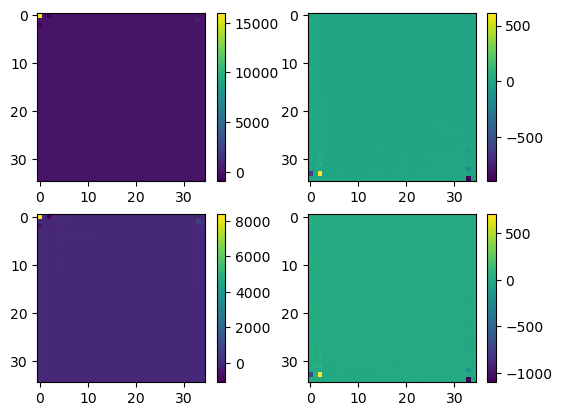

In [220]:
outputs = pinn.net(obs_inputs.astype(np.float32))

u = outputs[:,0].numpy()
v = outputs[:,1].numpy()
plt.subplot(221)
plt.imshow(to_2d(u[:35*35]))
plt.colorbar()
plt.subplot(222)
plt.imshow(to_2d(u[35*35:]))
plt.colorbar()
plt.subplot(223)
plt.imshow(to_2d(v[:35*35]))
plt.colorbar()
plt.subplot(224)
plt.imshow(to_2d(v[35*35:]))
plt.colorbar()
plt.show()

fft_outputs = tf.signal.fft2d(outputs.numpy().astype(np.complex64))
plt.subplot(221)
plt.imshow(to_2d( np.real(fft_outputs[:35*35,0])))
plt.colorbar()
plt.subplot(222)
plt.imshow(to_2d( np.real(fft_outputs[35*35:,0])))
plt.colorbar()
plt.subplot(223)
plt.imshow(to_2d( np.real(fft_outputs[:35*35,1])))
plt.colorbar()
plt.subplot(224)
plt.imshow(to_2d( np.real(fft_outputs[35*35:,1])))
plt.colorbar()